## 問題設定

状態ベクトルの次元$n=2$, 入力制御ベクトルの次元$m=1$とし, 線形システム

$$ \dot{x}(t) = Ax(t) + B u(t)$$

を考える. ここで
$$
A=\begin{bmatrix} 0 & 1\\ -6&-5\end{bmatrix},\quad
B=\begin{bmatrix} 0\\1 \end{bmatrix}
$$
とし, 初期値は
$$
x(0)=\begin{bmatrix} -1\\ 0\end{bmatrix}
$$

とする. 評価関数は

$$
J=\dfrac12 x^T(T) S_Tx(T) + \int_0^T\dfrac12\left(x^T(t)Qx(t) + u^T(t)Ru(t)\right)\, dt.
$$

において
$$
S_f=Q=\begin{bmatrix} 13& 0\\ 0&1\end{bmatrix},\quad
R=\begin{bmatrix} 1 \end{bmatrix}
$$
とする. すなわち

$$
J=\dfrac12 \left(13x_1(T)^2 + x_2(T)^2 \right) +\dfrac12 \int_0^T\left(13x_1(t)^2 + x_2(t)^2 +u(t)^2\right)\, dt.
$$

を最小化する最適制御を考える.
このときリッカチ方程式は

$$\left\{\begin{aligned}
&\dot{S}(t)+A^TS(t)+S(t)A-S(t)BR^{-1}B^TS(t)+Q=0,\\
&S(t_f)=S_f
\end{aligned}\right.$$

である. さらに,
$$\left\{\begin{aligned}
&\dot{x}(t)=(A-BR^{-1}B^TS(t))x(t),\\
&x(t_0)=x_0
\end{aligned}\right.$$

により状態ベクトルが得られ, $\lambda(t)=S(t)x(t)$, $u(t)=-R^{-1}B^T\lambda(t)$により随伴ベクトルも最適制御も得られる.


以下のステップで最適制御を求める

1. リッカチ方程式の解$S(t)$を求める
2. 状態方程式の解$x(t)$を$S(t)$を用いて求める
3. $\lambda(t)=S(t)x(t)$, $u(t)=-R^{-1}B^T\lambda(t)$により随伴ベクトルと最適制御を求める
3. 可視化

### 1. リッカチ方程式の解$S(t)$を求める

In [1]:
import diffrax
import jax.numpy as jnp

# 問題設定
A = jnp.array([[0, 1], [-6, -5]], dtype=float)
B = jnp.array([[0], [1]], dtype=float)

S_f = jnp.array([[13, 0], [0, 1]], dtype=float)
Q = jnp.array([[13, 0], [0, 1]], dtype=float)
R = jnp.array([[1]], dtype=float)

x_0 = jnp.array([[-1], [0]], dtype=float)

# 解く区間
t0, t1 = 0, 10
dt = 0.1

# diffrax の出力数
N = 1000

In [2]:
def vector_field(t, S, args):
    dot_S = A.T @ S + S @ A - S @ B @ jnp.linalg.inv(R) @ B.T @ S + Q
    return dot_S


term = diffrax.ODETerm(vector_field)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, N))
sol = diffrax.diffeqsolve(term, solver, t0, t1, dt, S_f, saveat=saveat)

S_t = sol.ys[::-1]

### 2. $x(t)$を求める

先程得た$S(t)$を用いて, $x(t)$は次の常微分方程式に従う
$$\left\{\begin{aligned}
&\dot{x}(t)=(A-BR^{-1}B^TS(t))x(t),\\
&x(t_0)=x_0
\end{aligned}\right.$$

In [3]:
def return_value_S_at_t(t):
    k = N * (t - t0) // (t1 - t0)
    return jnp.array(k, int)


def vector_field(t, x, args):
    k = return_value_S_at_t(t)
    dot_x = (A - B @ jnp.linalg.inv(R) @ B.T * S_t[k]) @ x
    return dot_x


term = diffrax.ODETerm(vector_field)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 1000))
sol = diffrax.diffeqsolve(term, solver, t0, t1, dt, x_0, saveat=saveat)

x_t = sol.ys
ts = sol.ts

### 3. $\lambda(t)=S(t)x(t)$, $u(t)=-R^{-1}B^T\lambda(t)$により随伴ベクトルも最適制御を得る

In [4]:
lambda_t = jnp.array([S_t[k] @ x_t[k] for k in range(len(ts))])
u_t = -jnp.linalg.inv(R) @ B.T @ jnp.array([lambda_t[k] for k in range(len(ts))])

### 4. 可視化

得られた状態ベクトル(左図)と制御入力(右図)をグラフを表示する

* 左図より, オーバーシュートは発生しているが抑えられていることがわかる
* 状態ベクトル, 制御入力ともに$k=5$あたりで$0$の十分近くに到達している

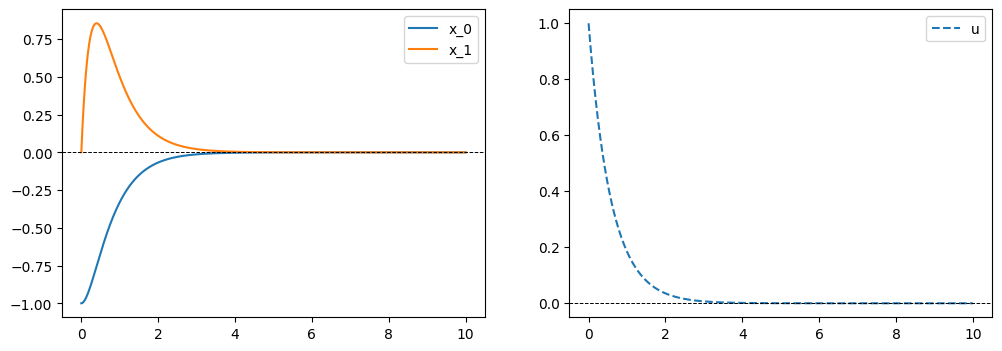

In [5]:
import matplotlib.pyplot as plt

X = jnp.array(x_t).reshape(N, 2)
U = jnp.array(u_t).reshape(N, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(2):
    plt.plot(ts, X[:, k], label=f"x_{k}")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()

plt.subplot(1, 2, 2)
for k in range(1):
    plt.plot(ts, U[:, k], linestyle="--", label="u")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()
plt.show()

## リッカチ方程式の解法

リッカチ方程式は非線形方程式だが、次のような変換で線形常微分方程式系と書き直せる. $P(t)=S(T-t)$と置き, 更に対称行列の積$P(t)=E(t)D(t)$, $E(0)=S(T), D(0)=I$と置くと,
$E(t),D(t)$の従う常微分方程式として

$$\left\{\begin{aligned}
\dot{E}(t) &= A^TE(t) +QD(t),\\
\dot{D}(t) &= B^TR^{-1} BE(t) - AD(t)
\end{aligned}\right.$$

を得る. このことは, $P(t)=E(t)D(t)$ がリッカチ方程式（の時間逆向き）を満たすことを以下の公式に注意して計算することで分かる;

$$
\dfrac{d}{dt}\left(D(t)^{-1}\right) = -D(t)^{-1}\dot{D}(t)D(t)^{-1}
$$

以下では, リッカチ方程式の解を求めるステップをこの事実で置き換えた場合を使って検証する. ただし, この形でさえ手計算で求めるのは相当に時間がかかるため, SymPy を用いた計算により行う.

In [22]:
import sympy as sp

s, t = sp.symbols("s t")

In [7]:
K = sp.Matrix([[0, -6, 13, 0], [1, -5, 0, 1], [0, 0, 0, -1], [0, 1, 6, 5]])
inverse_sI_minus_K = (s * sp.eye(4) - K).inv()

exp_At = sp.inverse_laplace_transform(inverse_sI_minus_K, s, t)

In [9]:
initial = sp.Matrix([[13, 0], [0, 1], [1, 0], [0, 1]])
ED = exp_At * initial

sympy.matrices.dense.MutableDenseMatrix

In [10]:
E = ED[:2, :]
E.simplify()
D = ED[2:, :]
D_inv = D.inv()
D_inv.simplify()
P = E * D_inv

In [13]:
# numpy 配列への変換を行う
t_values = jnp.linspace(t0, t1, 1000)

result_matrices = jnp.array([jnp.array(P.subs(t, t_val), dtype=float) for t_val in t_values])
result_matrices = result_matrices[::-1]

In [15]:
# ここから先は同じように最適制御を求める
def vector_field_(t, x, args):
    k = return_value_S_at_t(t)
    dot_x = (A - B @ jnp.linalg.inv(R) @ B.T * result_matrices[k]) @ x
    return dot_x


term = diffrax.ODETerm(vector_field_)
solver = diffrax.Tsit5()
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 1000))
sol = diffrax.diffeqsolve(term, solver, t0, t1, dt, x_0, saveat=saveat)

x_t = sol.ys
ts = sol.ts

In [16]:
lambda_t = jnp.array([result_matrices[k] @ x_t[k] for k in range(len(ts))])
u_t = -jnp.linalg.inv(R) @ B.T @ jnp.array([lambda_t[k] for k in range(len(ts))])

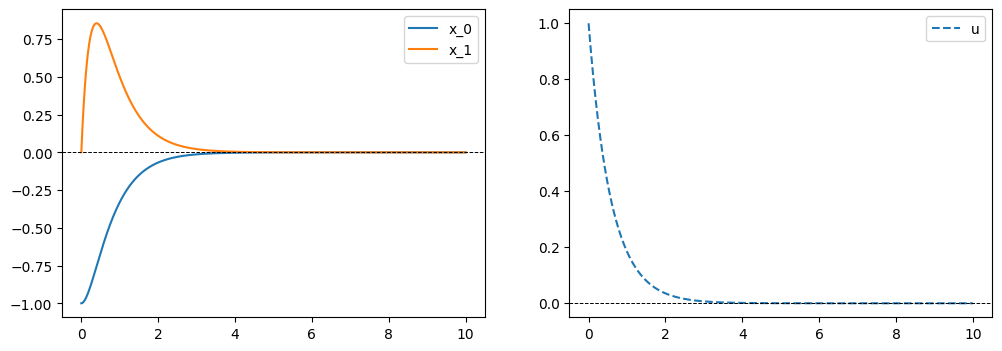

In [17]:
X = jnp.array(x_t).reshape(N, 2)
U = jnp.array(u_t).reshape(N, 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for k in range(2):
    plt.plot(ts, X[:, k], label=f"x_{k}")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()

plt.subplot(1, 2, 2)
for k in range(1):
    plt.plot(ts, U[:, k], linestyle="--", label="u")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.legend()

plt.show()

In [21]:
diff_S = S_t - result_matrices

print(diff_S.max(), S_t.max())

Array(0.00063992, dtype=float32)